In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import normalize
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import CategoricalNB, GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, \
average_precision_score, roc_auc_score, plot_precision_recall_curve, plot_roc_curve, plot_confusion_matrix 
from sklearn.exceptions import ConvergenceWarning

from xgboost import XGBClassifier, XGBRFClassifier, plot_importance

from imblearn.over_sampling import SMOTENC

import matplotlib.pyplot as plt

import warnings

from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer

from IPython.display import clear_output


import pickle

import os
import sys
module_path = os.path.abspath(os.path.join(os.pardir))
if module_path not in sys.path:
    sys.path.append(module_path)
from src.functions import test_model, get_timeseries_table, add_model,\
add_hypersearch

from seaborn import heatmap

warnings.filterwarnings("ignore", category=ConvergenceWarning)

In [2]:
def return_score(optim_result):
    """
    callback for a hyperparameter search.  Displays current best score and 
    best parameters.  To be added to the fit method, callback argument.
    """
    score = opt.best_score_
    params = pd.DataFrame(opt.best_params_, index=[0])
    clear_output()
    print('Best Score So Far: ', score)
    print('Using Parameters: ', params)

In [3]:
prediction_window = 135

df = get_timeseries_table(prediction_window=prediction_window,
                         binary_labels=True, one_hot_modules=True)

X = df.drop(columns=['final_result'])
y = df['final_result']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=111)
X_t, X_val, y_t, y_val = train_test_split(X_train, y_train, random_state=111)

all_features = 'SMOTED activites, clicks, activities*clicks, assessments, modules'

X_t_normal = normalize(X_t)
X_val_normal = normalize(X_val)
X_train_normal = normalize(X_train)
X_test_normal = normalize(X_test)

assessments merged:  1


In [4]:
models = [LogisticRegression(random_state=111, solver='liblinear'),
         DecisionTreeClassifier(random_state=111),
         RandomForestClassifier(random_state=111),
         KNeighborsClassifier(),
         SVC(random_state=111, probability=True),
         SGDClassifier(loss='log', random_state=111),
         AdaBoostClassifier(random_state=111),
         XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=111),      
         ]

for model in models:
    model.fit(X_t, y_t)
    add_model(model, X_t, y_t, X_val, y_val, 
              preprocessing=None, 
              features = all_features)


In [5]:
models = [LogisticRegression(random_state=111, solver='liblinear'),
         DecisionTreeClassifier(random_state=111),
         RandomForestClassifier(random_state=111),
         CategoricalNB(),
         GaussianNB(),
         KNeighborsClassifier(),
         SVC(random_state=111, probability=True),
         AdaBoostClassifier(random_state=111),
         XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=111)      
         ]

for model in models:
    model.fit(X_t_normal, y_t)
    add_model(model, X_t_normal, y_t, X_val_normal, y_val, 
              features = all_features,
              preprocessing='normalized')


h_table = None

In [6]:
xgb = XGBClassifier(use_label_encoder=False, seed=111, eval_metric='logloss')

xgb_search_space = {'objective': Categorical(['binary:logistic',
                                              'binary:hinge']),
                    'eval_metric': Categorical(['logloss','error']),
                   'learning_rate': Real(0.05, .3, 'log-uniform'),
                   'min_child_weight': Integer(1,10, 'uniform'),
                   'max_depth': Integer(20,60, 'normal'),
                   'subsample': Real(0.3, 1, 'normal'),
                   'colsample_bytree': Real(.3, 1.0, 'normal'),
                   'scale_pos_weight': Real(.5, 2.0, 'uniform')}

opt = BayesSearchCV(xgb, search_spaces=xgb_search_space, 
                    n_iter=50, cv=2,
                    n_jobs=4,
                    pre_dispatch = 8,
                    random_state=111,
                    return_train_score=True,
                    scoring='roc_auc')

opt.fit(X_t, y_t, callback=[return_score])

XGBmodel = opt.best_estimator_

add_hypersearch(opt)

add_model(XGBmodel, X_t, y_t, X_val, y_val, 
          features = all_features,
          preprocessing=None)

Best Score So Far:  0.8966287362475831
Using Parameters:     colsample_bytree eval_metric  learning_rate  max_depth  min_child_weight  \
0          0.530671     logloss           0.05         60                10   

         objective  scale_pos_weight  subsample  
0  binary:logistic               0.5   0.824411  


In [7]:
rf = RandomForestClassifier(random_state=111)

rf_search_space = {'n_estimators': Integer(50, 500, 'normal'),
                   'max_depth': Integer(5, 50, 'normal'),
                   'max_features': Categorical(['sqrt','log2',None]),
                   'class_weight': Categorical(['balanced','balanced_subsample',None]),
                   'max_samples': Real(.1, .99, 'uniform')
                   }

opt = BayesSearchCV(rf, search_spaces=rf_search_space, 
                    n_iter=50, cv=2,
                    n_jobs=4,
                    pre_dispatch = 8,
                    random_state=111,
                    return_train_score=True,
                    scoring='roc_auc')

opt.fit(X_t, y_t, callback=[return_score])

RFclf = opt.best_estimator_

add_hypersearch(opt)

add_model(RFclf, X_t, y_t, X_val, y_val, 
          features=all_features, 
          preprocessing=None)

Best Score So Far:  0.880268294038091
Using Parameters:    class_weight  max_depth max_features  max_samples  n_estimators
0     balanced         50         None     0.415206           474


In [8]:
DT = DecisionTreeClassifier(random_state=111)

DT_search_space = {'criterion': Categorical(['gini','entropy']),
                   'splitter': Categorical(['best','random']),
                    'max_depth': Integer(3,10, 'uniform'),
                   'max_features': Categorical(['sqrt','log2', None]),
                   'class_weight': Categorical(['balanced',None]),
                   }

opt = BayesSearchCV(DT, search_spaces=DT_search_space, 
                    n_iter=50, cv=2,
                    n_jobs=4,
                    pre_dispatch = 8,
                    random_state=111,
                    scoring='roc_auc',
                    return_train_score=True)

opt.fit(X_t, y_t, callback=[return_score])

DTclf = opt.best_estimator_

add_hypersearch(opt)

add_model(DTclf, X_t, y_t, X_val, y_val, 
          features=all_features, 
          preprocessing=None)

Best Score So Far:  0.8365725117487224
Using Parameters:    class_weight criterion  max_depth max_features splitter
0     balanced   entropy          5         None     best


In [10]:
table = pd.read_csv('hyperparameter_table.csv')
table.head(20)

,model,val_roc_auc,train_roc_auc,val_accuracy,train_accuracy,val_f1_score,train_f1_score,features,preprocessing,C,...,subsample,tree_method,validate_parameters,verbosity,eval_metric,class_prior,fit_prior,priors,var_smoothing,seed
0,XGBClassifier,0.934449,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.857405,NaN,NaN,NaN,logloss,NaN,NaN,NaN,NaN,NaN
1,XGBClassifier,0.934330,0.999999,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.000000,NaN,NaN,NaN,logloss,NaN,NaN,NaN,NaN,NaN
2,XGBClassifier,0.933969,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.000000,NaN,NaN,NaN,logloss,NaN,NaN,NaN,NaN,NaN
3,XGBClassifier,0.933770,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.000000,NaN,NaN,NaN,error,NaN,NaN,NaN,NaN,NaN
4,XGBClassifier,0.933645,0.999990,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.000000,NaN,NaN,NaN,logloss,NaN,NaN,NaN,NaN,NaN
5,XGBClassifier,0.933574,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.000000,NaN,NaN,NaN,error,NaN,NaN,NaN,NaN,NaN
6,XGBClassifier,0.933343,0.999987,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.712164,NaN,NaN,NaN,logloss,NaN,NaN,NaN,NaN,NaN
7,XGBClassifier,0.933236,0.999999,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.000000,NaN,NaN,NaN,error,NaN,NaN,NaN,NaN,NaN
8,XGBClassifier,0.933139,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.000000,NaN,NaN,NaN,logloss,NaN,NaN,NaN,NaN,NaN
9,XGBClassifier,0.932609,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.969674,NaN,NaN,NaN,logloss,NaN,NaN,NaN,NaN,NaN


In [12]:
clf=XGBmodel

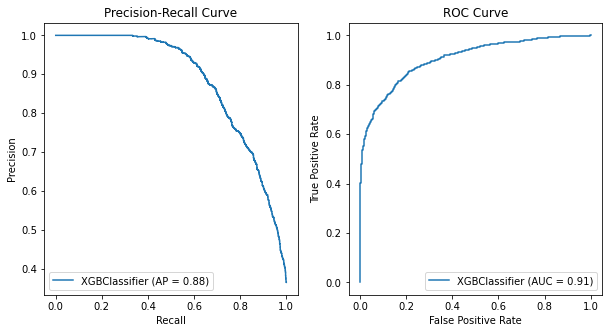

In [13]:
y_score = clf.predict_proba(X_val)[:,1]

fig, axes = plt.subplots(1,2, figsize=(10,5))
plot_precision_recall_curve(clf, X_val, y_val, ax = axes[0])
axes[0].set_title('Precision-Recall Curve')

plot_roc_curve(clf, X_val, y_val, ax= axes[1])
axes[1].set_title('ROC Curve')
plt.show()

In [14]:
thresh_accuracy = pd.DataFrame(columns= ['accuracy', 'f1_score'],
                              index = [x/100 for x in range(60,80)])

thresh_accuracy.index.name = 'Threshold'
for thresh in range(10, 90):
    thresh /= 100
    yhat = pd.Series(y_score).apply(lambda x: 1 if x >= thresh else 0)
    accuracy = accuracy_score(y_val, yhat)
    f1 = f1_score(y_val, yhat)
    roc = roc_auc_score(y_val, y_score)
    pr = average_precision_score(y_val, y_score)
    thresh_accuracy.loc[thresh, 'accuracy'] = accuracy
    thresh_accuracy.loc[thresh, 'f1_score'] = f1

print('ROC_AUC: ', roc)
print('PR_AUC: ', pr)
thresh_accuracy = thresh_accuracy.sort_values(by='f1_score', ascending=False)
thresh_accuracy.head(20)

ROC_AUC:  0.905456653573269
PR_AUC:  0.8824042695864506


,accuracy,f1_score
Threshold,,
0.22,0.829371,0.77305
0.21,0.826705,0.772462
0.26,0.836259,0.771615
0.20,0.822928,0.770251
0.34,0.84559,0.769944
0.30,0.840036,0.769674
0.33,0.843812,0.769281
0.23,0.828705,0.769231
0.27,0.835592,0.768894


<AxesSubplot:>

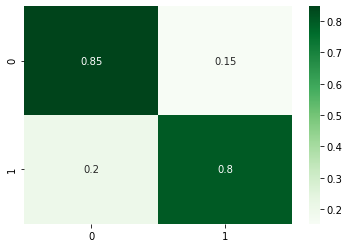

In [15]:
yhat = pd.Series(y_score)
best_thresh = thresh_accuracy.index[0]
yhat = yhat.apply(lambda x: 1 if x >= best_thresh else 0)

confusion  = confusion_matrix(y_val, yhat, normalize='true')
heatmap(confusion, annot=True, cmap='Greens')

In [16]:
importance = pd.DataFrame(XGBmodel.feature_importances_, index=X_t.columns)
importance.sort_values(by=0, ascending=False).head(20)

,0
assess_score_2,0.018006
module_CCC,0.013691
module_GGG,0.012252
sum_activities_123,0.010819
assess_score_3,0.009962
sum_click_131,0.007797
sum_activities_133,0.007702
sum_activities_117,0.007641
sum_click_123,0.007448
sum_activities_131,0.007334


import pickle
pickle.dump(clf, open('time_series_xgb_best.pkl','wb'))